# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
round(-(0.8*np.log(0.8) + 0.2*np.log(0.2)), 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
round(0.8*0.2 + 0.2*0.8 - np.abs(0.8)*1 * (1-1) - np.abs(0.2)*1 * (1-1), 2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
my_leaf = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
np.mean(my_leaf)

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов берется среднее двух сосдених (при сортировке) значений признака

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    feature_values = np.unique(feature_vector)
    Q_array = []
    threshold = []
    if feature_type =="real":
      if task == "regression":
        for t in range(len(feature_values)- 1):
          R_l = feature_vector[np.where(feature_vector < ((feature_values[t] + feature_values[t+1])/2))]
          R_r = feature_vector[np.where(feature_vector >= ((feature_values[t] + feature_values[t+1])/2))]
          target_l = target_vector[np.where(feature_vector < ((feature_values[t] + feature_values[t+1])/2))]
          target_r = target_vector[np.where(feature_vector >= ((feature_values[t] + feature_values[t+1])/2))]
          Q = len(R_l) / len(feature_vector) * target_l.var() + len(R_r) / len(feature_vector) * target_r.var()
          threshold.append((feature_values[t] + feature_values[t+1])/2)
          Q_array.append(Q)
      elif task == "classification":
        for t in range(len(feature_values)- 1):
          R_l = feature_vector[np.where(feature_vector < ((feature_values[t] + feature_values[t+1])/2))]
          R_r = feature_vector[np.where(feature_vector >= ((feature_values[t] + feature_values[t+1])/2))]
          target_l = target_vector[np.where(feature_vector < ((feature_values[t] + feature_values[t+1])/2))]
          target_r = target_vector[np.where(feature_vector >= ((feature_values[t] + feature_values[t+1])/2))]
          target_l_freq = np.sum(np.unique(target_l, return_counts=True)[1] / len(target_l) * (1 - (np.unique(target_l, return_counts=True)[1] / len(target_l))))
          target_r_freq = np.sum(np.unique(target_r, return_counts=True)[1] / len(target_r) * (1 - (np.unique(target_r, return_counts=True)[1] / len(target_r))))
          Q = len(R_l) / len(feature_vector) * target_l_freq + len(R_r) / len(feature_vector) * target_r_freq
          threshold.append((feature_values[t] + feature_values[t+1])/2)
          Q_array.append(Q)
    elif feature_type == "categorical":
      if task == "regression":
        for t in range(len(feature_values)):
          R_l = feature_vector[np.where(feature_vector == feature_values[t])]
          R_r = feature_vector[np.where(feature_vector != feature_values[t])]
          target_l = target_vector[np.where(feature_vector == feature_values[t])]
          target_r = target_vector[np.where(feature_vector != feature_values[t])]
          Q = len(R_l) / len(feature_vector) * target_l.var() + len(R_r) / len(feature_vector) * target_r.var()
          threshold.append(feature_values[t])
          Q_array.append(Q)
      elif task == "classification":
        for t in range(len(feature_values)):
          R_l = feature_vector[np.where(feature_vector == feature_values[t])]
          R_r = feature_vector[np.where(feature_vector != feature_values[t])]
          target_l = target_vector[np.where(feature_vector == feature_values[t])]
          target_r = target_vector[np.where(feature_vector != feature_values[t])]
          target_l_freq = np.sum(np.unique(target_l, return_counts=True)[1] / len(target_l) * (1 - (np.unique(target_l, return_counts=True)[1] / len(target_l))))
          target_r_freq = np.sum(np.unique(target_r, return_counts=True)[1] / len(target_r) * (1 - (np.unique(target_r, return_counts=True)[1] / len(target_r))))
          Q = len(R_l) / len(feature_vector) * target_l_freq + len(R_r) / len(feature_vector) * target_r_freq
          threshold.append(feature_values[t])
          Q_array.append(Q)

    Q_array = np.nan_to_num(Q_array, nan=float("+inf"))
    threshold_best = threshold[np.argmin(Q_array)]
    gini_best = Q_array[np.argmin(Q_array)]

    return threshold, Q_array, threshold_best, gini_best

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [ ]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

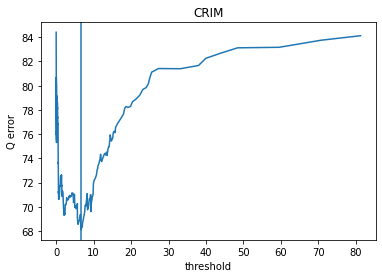

In [ ]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)
plt.plot(thresholds, variances)
plt.title("CRIM")
plt.xlabel("threshold")
plt.ylabel("Q error")
plt.axvline(x=threshold_best)
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [ ]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
              feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
              feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini < gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best 
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        else:
            feature_type = self._feature_types[node['feature_split']]
            if feature_type == 'real':
                if x[node['feature_split']] < node['threshold']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            else:
                if x[node['feature_split']] == node["category_split"]:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
! wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2022/homeworks/hw07-trees/students.csv

--2022-06-05 15:25:34--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2022/homeworks/hw07-trees/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv’


students.csv          0%[                    ]       0  --.-KB/s               
students.csv        100%[===================>]   7.61K  --.-KB/s    in 0s      

2022-06-05 15:25:34 (82.2 MB/s) - ‘students.csv’ saved [7794/7794]



In [ ]:
data = pd.read_csv('students.csv', decimal=",", index_col = 0)
y_target = data['UNS']
data = data.drop(columns = 'UNS')
df = data.apply(pd.to_numeric)
y_target = y_target.apply(pd.to_numeric).to_numpy()

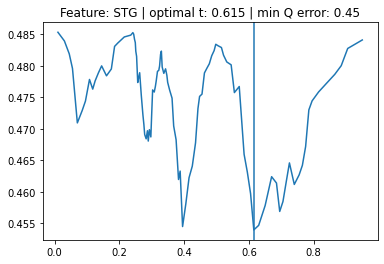

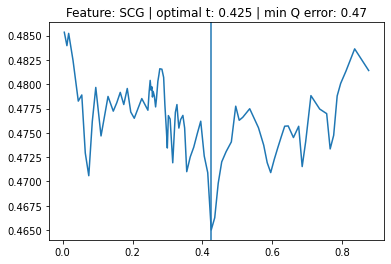

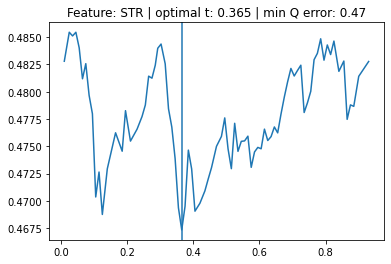

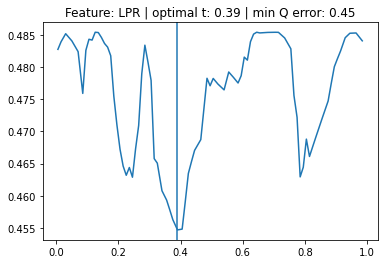

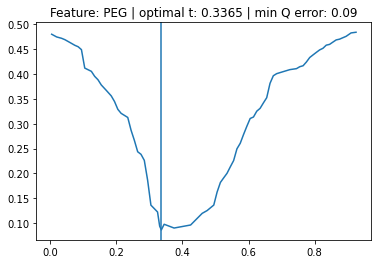

In [ ]:
results = []

for f in df.columns:
    thresholds, variances, threshold_best, variance_best = find_best_split(
    df[f].to_numpy(), 
    y_target, 
    task="classification",
    feature_type="real"
)

    plt.figure()
    plt.title("Feature: {} | optimal t: {} | min Q error: {:.2f}".format(f, threshold_best, variance_best))
    plt.plot(thresholds, variances)
    plt.axvline(x=threshold_best)
    plt.show()


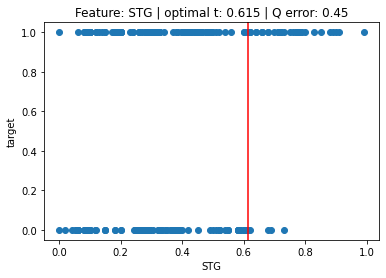

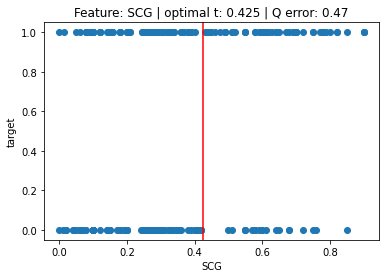

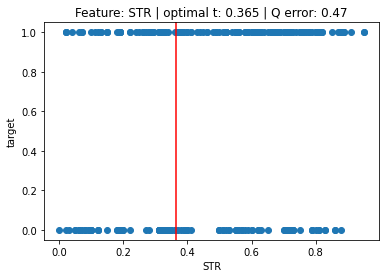

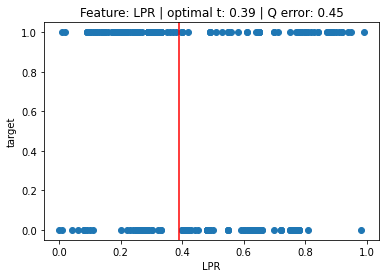

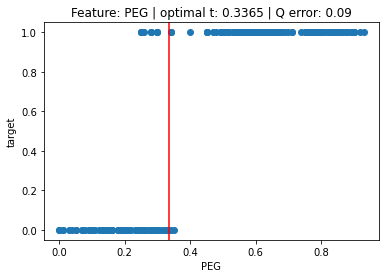

In [ ]:
for f in df.columns:
  thresholds, variances, threshold_best, variance_best = find_best_split(
    df[f].to_numpy(), 
    y_target, 
    task="classification",
    feature_type="real")
  plt.scatter(df[f], y_target)
  plt.axvline(x=threshold_best, color="red")
  plt.xlabel(f)
  plt.ylabel("target")
  plt.title("Feature: {} | optimal t: {} | Q error: {:.2f}".format(f, threshold_best, variance_best))
  plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

По признаку PEG, так как там достигается минимальное значение критерия Джини (Q_min_error = 0.09), рассчитанное в дочерних вершинах, (мера хаотичности) => максимальное значение критерия информативности. Результат согласуется с диаграммой рассеяния (слева от порога попадают почти все объекты 0-ого класса, а справа - 1-го класса => в каждую из вершин попадут почти все объекты одного класса). Кривая для "хороших" признаков должна принимать вид некой параболы с 1 минимумом. Кривые для признаков, деление по которым почти невозможно, отличаются большим количеством локальных минимумов => не можем разделить объекты так, чтобы в каждую из вершин попали объекты +- из одного класса.


**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
! wget https://raw.githubusercontent.com/smnvkaty/hw7/main/agaricus-lepiota.data

--2022-06-05 15:29:17--  https://raw.githubusercontent.com/smnvkaty/hw7/main/agaricus-lepiota.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373704 (365K) [text/plain]
Saving to: ‘agaricus-lepiota.data’


agaricus-lepiota.da   0%[                    ]       0  --.-KB/s               
agaricus-lepiota.da 100%[===================>] 364.95K  --.-KB/s    in 0.03s   

2022-06-05 15:29:18 (10.7 MB/s) - ‘agaricus-lepiota.data’ saved [373704/373704]



In [ ]:
dt = pd.read_csv('agaricus-lepiota.data', sep=",")

In [ ]:
from sklearn.preprocessing import LabelEncoder
dt = dt.apply(LabelEncoder().fit_transform)

In [ ]:
y = dt['p']
dt = dt.drop(columns='p')
dt_new = dt.apply(pd.to_numeric)
y_target_new = y.apply(pd.to_numeric).to_numpy()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dt.values, y.values,
                                                    test_size=0.5, random_state=13)

In [ ]:
feature_types = ['categorical' for x in X_train]
tree = DecisionTree(feature_types)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print('test accuracy =', np.sum(y_pred == y_test) / np.size(y_test))

test accuracy = 0.9972919743968488


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
! wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2022/homeworks/hw07-trees/diabetes.csv

--2022-06-05 15:29:56--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2022/homeworks/hw07-trees/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23105 (23K) [text/plain]
Saving to: ‘diabetes.csv’


diabetes.csv          0%[                    ]       0  --.-KB/s               
diabetes.csv        100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2022-06-05 15:29:56 (26.6 MB/s) - ‘diabetes.csv’ saved [23105/23105]



In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

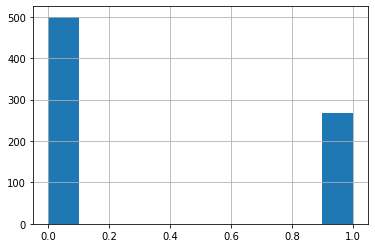

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
y = data['Outcome']
data = data.drop(columns = 'Outcome')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state = 13, shuffle = True)

In [ ]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state= 13, shuffle = True)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
max_depth_list = np.arange(15)
min_samples_leaf_list = np.arange(15)
storage = []
for i in max_depth_list[1:]:
  for j in min_samples_leaf_list[1:]:
    dt = DecisionTreeClassifier(min_samples_leaf = j, max_depth = i, random_state=13)
    dt.fit(X_train_2, y_train_2)
    y_pred_dt = dt.predict(X_val)
    storage.append([f1_score(y_pred_dt, y_val), i, j])
    #print(f"Decision tree f1-metrics: {f1_score(y_pred_dt, y_val):.2f} with max_depth {i}")
storage.sort(key=lambda x: x[0], reverse=True)
print(f"Decision tree best f1-metrics: {storage[0][0]:.2f} with max_depth {storage[0][1]} and min_samples_leaf {storage[0][2]}")

Decision tree best f1-metrics: 0.66 with max_depth 5 and min_samples_leaf 1


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 1, random_state=13)
dt.fit(X_train, y_train)
y_pred_tree = dt.predict(X_test)
print(f'Roc_auc_score: {round(roc_auc_score(y_test, y_pred_tree), 2)}')
print(classification_report(y_test, y_pred_tree))


Roc_auc_score: 0.67
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       144
           1       0.65      0.51      0.57        87

    accuracy                           0.71       231
   macro avg       0.69      0.67      0.67       231
weighted avg       0.70      0.71      0.70       231



**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
from sklearn.ensemble import BaggingClassifier 

In [ ]:
bag = BaggingClassifier(base_estimator= dt,
                       n_estimators=50,
                       random_state=13)

In [ ]:
bag.fit(X_train, y_train)
y_pred_ens_tree = bag.predict(X_test)
print(f'Roc_auc_score: {round(roc_auc_score(y_test, y_pred_ens_tree), 2)}')
print(classification_report(y_test, y_pred_ens_tree))

Roc_auc_score: 0.72
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       144
           1       0.73      0.56      0.64        87

    accuracy                           0.76       231
   macro avg       0.75      0.72      0.73       231
weighted avg       0.75      0.76      0.75       231



**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
max_depth_list = np.arange(15)
min_samples_leaf_list = np.arange(15)
storage = []
for i in min_samples_leaf_list[1:]:
  for j in max_depth_list[1:]:
    rfr = RandomForestClassifier(n_estimators = 50,max_depth = j, min_samples_leaf = i, random_state=13)
    scores = cross_val_score(rfr, X_train, y_train, cv=5, scoring='f1')
    storage.append(["%0.3f f1_score" % (scores.mean()), f'max_depth: {j}', f'min_samples_leaf: {i}'])
storage.sort(key=lambda x: x[0], reverse=True)
print(storage[0])

['0.647 f1_score', 'max_depth: 7', 'min_samples_leaf: 2']


In [ ]:
rfr = RandomForestClassifier(n_estimators = 50,max_depth = 7, min_samples_leaf = 2, random_state=13)
rfr.fit(X_train, y_train)
y_pred_ens_tree = rfr.predict(X_test)
print(f'Roc_auc_score: {round(roc_auc_score(y_test, y_pred_ens_tree), 2)}')
print(classification_report(y_test, y_pred_ens_tree))

Roc_auc_score: 0.73
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       144
           1       0.75      0.59      0.66        87

    accuracy                           0.77       231
   macro avg       0.76      0.73      0.74       231
weighted avg       0.77      0.77      0.76       231



У последней модели самое высокое значение roc_auc_score (0,73), аккураси (0,77), точности (верно определили, что диабетик - действительно диабетик среди всех, кому поставили положительный диагноз), полноты (сколько верно поставленных диагнозов среди всех реально болеющих пациентов). Также улучшилась f1-метрика.


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
store = []
for i in np.arange(200)[1:]:
  rfr = RandomForestClassifier(n_estimators = i ,max_depth = 7, min_samples_leaf = 2, random_state=13)
  rfr.fit(X_train, y_train)
  y_pred_rand_for = rfr.predict(X_test)
  store.append(roc_auc_score(y_test, y_pred_rand_for))

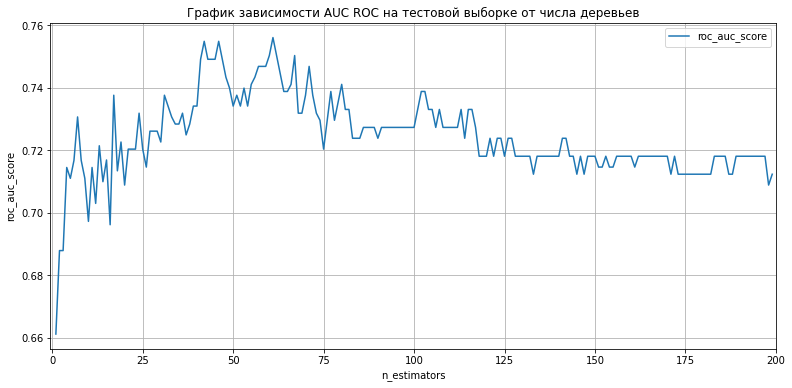

In [ ]:
plt.figure(figsize=(13, 6))
plt.plot(range(1, 200), store, label='roc_auc_score')

plt.title('График зависимости AUC ROC на тестовой выборке от числа деревьев')
plt.xlim((-0.5, 200))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel(r'roc_auc_score')
plt.grid()
plt.show()

Кажется, что до какого-то момента с ростом деревьев auc-roc на тесте увеличивается, а потом выходит на асимптоту => примерно 100 деревьев необходимо обучить, чтобы получить максимально возможное значение auc-roc на тесте.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
rfr = RandomForestClassifier(n_estimators = i ,max_depth = 7, min_samples_leaf = 2, random_state=13)
rfr.fit(X_train, y_train)
y_pred_ens_tree = rfr.predict(X_test)

<BarContainer object of 8 artists>

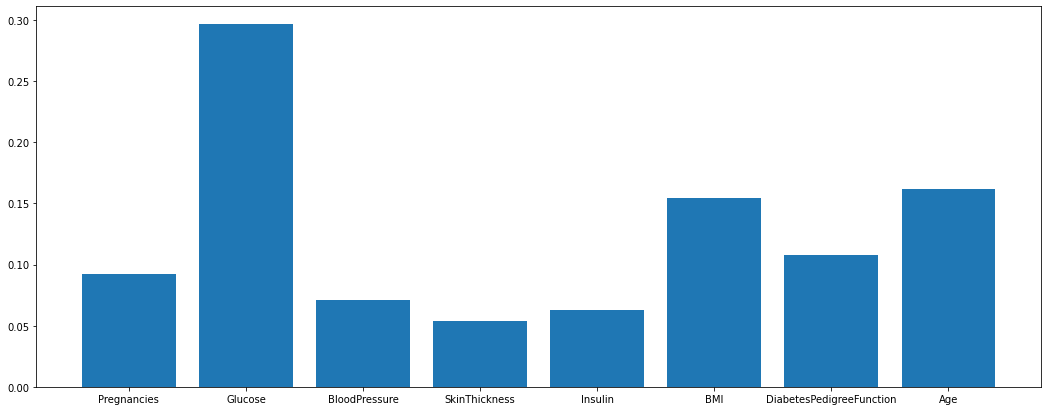

In [ ]:
plt.figure(figsize = (18, 7))
plt.bar(data.columns, rfr.feature_importances_)

Самый важный признак - уровень глюкозы в крови.
